<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predvidjanje vrednosti Bitcoina za DAYS_TO_PREDICT dana korišćenjem GRU (RNN)**

**Korišćeni atributi:** Close

**Filtrirani podaci:** od 28.03.2021.

**Napomena:** Podaci koje predstavljaju vrednosti bitkoina dati su u minutima.

**Koraci:**
1. Učitavanje i pretprocesiranje podataka
2. Podela skupa podataka na skupove za trening, validaciju i test
3. Filtriranje kolona (atributa)
4. Skaliranje podataka
5. Odredjivanje ciljne promenljive
6. Kreiranje modela mreže
7. Kompilacija i treniranje mreže
8. Predvidjanje
9. Evaluacija

## **Učitavanje biblioteka**

In [2]:
import numpy as np 
import pandas as pd 
import os

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.layers import GRU,CuDNNGRU
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.losses import MeanSquaredError

%run Preprocessing.ipynb
#%run Utility.ipynb

### **Učitavanje skupa podataka i pretprocesiranje**

In [3]:
data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [4]:
data = filter_data(data, date_str = '2021-03-28')

In [5]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4854496,1616976000,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695,2021-03-29
4854497,1616976060,55822.98,55857.28,55822.98,55857.28,0.589603,32931.781301,55854.182542,2021-03-29
4854498,1616976120,55822.98,55829.04,55766.15,55779.04,2.729659,152263.034630,55780.964698,2021-03-29
4854500,1616976240,55766.15,55768.63,55766.15,55768.63,0.023738,1323.776861,55766.455065,2021-03-29
4854501,1616976300,55770.46,55778.48,55736.83,55742.20,0.389067,21692.454676,55755.006032,2021-03-29


### **Podela skupa podataka**

In [57]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2)

# Podela train skupa podataka na train i validation skup

train, validation = data_split(data, test_size = 0.2)

In [58]:
# Dimenzije train, validacionog i test skupa

train.shape, validation.shape, test.shape

((2298, 9), (574, 9), (574, 9))

### **Vizualizacija podataka**

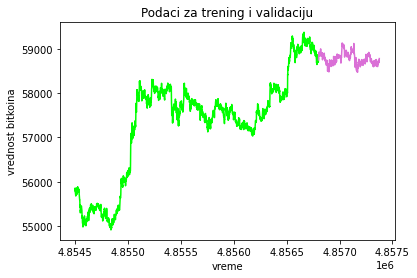

In [60]:
# Plotovanje trening skupa i validacionog skupa podataka

plot_train_and_validation_data(train = train['Close'], validation = validation['Close'])

### **Filtriranje kolona**

In [61]:
# Izbacivanje nepotrebnih kolona (atributa) iz train skupa

train_ = train.drop(['Open', 'High', 'Low', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head()

,Close
4854496,55804.36
4854497,55857.28
4854498,55779.04
4854500,55768.63
4854501,55742.20


In [62]:
# Izbacivanje nepotrebnih kolona (atributa) iz validacionog skupa

validation_ = validation.drop(['Low', 'High', 'Open', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
validation_.head()

,Close
4856801,58747.90
4856802,58825.89
4856803,58828.09
4856804,58835.62
4856805,58900.00


In [63]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Low', 'High', 'Open', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
test_.head()

,Close
4856801,58747.90
4856802,58825.89
4856803,58828.09
4856804,58835.62
4856805,58900.00


In [64]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((2298, 9), (2298, 1))

### **Skaliranje**

In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Skaliranje trening skupa

train_ = scaler.fit_transform(train_)
print(train_)

# Skaliranje validacionog skupa

validation_ = scaler.transform(validation_)
print(validation_)

# Skaliranje test skupa

test_ = scaler.transform(test_)
print(test_)

[[0.19947492]
 [0.21134984]
 [0.19379327]
 ...
 [0.84805843]
 [0.84788789]
 [0.86661356]]
[[0.85998721]
 [0.87748769]
 [0.87798135]
 [0.87967104]
 [0.89411752]
 [0.88930875]
 [0.90001683]
 [0.892365  ]
 [0.89619765]
 [0.89169631]
 [0.88706482]
 [0.883111  ]
 [0.890976  ]
 [0.88471541]
 [0.87884078]
 [0.884592  ]
 [0.89078527]
 [0.88658461]
 [0.90969494]
 [0.91040627]
 [0.91591065]
 [0.91091788]
 [0.89896891]
 [0.89149435]
 [0.890884  ]
 [0.88585758]
 [0.88617173]
 [0.88167488]
 [0.88606626]
 [0.88514625]
 [0.88289782]
 [0.88189703]
 [0.87901581]
 [0.88255226]
 [0.89066185]
 [0.89656341]
 [0.87681675]
 [0.87034523]
 [0.86045844]
 [0.87162876]
 [0.87796789]
 [0.88213264]
 [0.87951845]
 [0.88105106]
 [0.88396594]
 [0.88037115]
 [0.87892156]
 [0.88267343]
 [0.86943419]
 [0.87643304]
 [0.88933119]
 [0.88828776]
 [0.88823391]
 [0.88563543]
 [0.89429703]
 [0.88533474]
 [0.87291678]
 [0.8683571 ]
 [0.863398  ]
 [0.85969325]
 [0.85709253]
 [0.85961472]
 [0.8729841 ]
 [0.87084338]
 [0.85860494]


### **Odredjivanje ciljne promenljive**

In [67]:
# Odredjivanje ciljne promenljive na train skupu

X_train, y_train = determine_x_and_y(dataset = train_)


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation, y_validation = determine_x_and_y(dataset = validation_)


# Odredjivanje ciljne promenljive na test skupu

X_test, y_test = determine_x_and_y(dataset = test_)

In [68]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_test, y_test = np.array(X_test), np.array(y_test)

In [69]:
# Dimenzije X_train

X_train.shape

(2238, 60, 1)

### **Kreiranje, kompilacija i treniranje mreže**

**Kreiranje mreže**

In [70]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(step_size = X_train.shape[1], units = 50, nb_features = X_train.shape[2], output_size = 16):

  net = Sequential()
  net.add(GRU(units = units, input_shape = (step_size, nb_features), return_sequences=False))
  net.add(Activation('tanh'))
  net.add(Dropout(0.2))
  net.add(Dense(output_size))
  net.add(Activation('relu'))
  
  print(net.summary())

  return net


In [71]:
# Zadavanje parametara

step_size = X_train.shape[1]
units = 50
nb_features = X_train.shape[2]
output_size = 16

In [72]:
# Kreiranje modela mreze

net = build_net(step_size = X_train.shape[1], units = 50, nb_features = X_train.shape[2], output_size = 16)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 50)                7950      
_________________________________________________________________
activation_4 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
Total params: 8,766
Trainable params: 8,766
Non-trainable params: 0
_________________________________________________________________
None


**Kompilacija i treniranje mreže**

In [85]:
# Definicija funkcije za kompilaciju i treniranje mreze
# Treniranje je moguce vrsiti sa ili bez validacije

def compile_and_fit(optimizer, loss, metrics, X_train_, y_train_, epochs, validation = 1, validation_data = None, batch_size = 50, patience = 3):

  net.compile(loss = loss, optimizer = optimizer, metrics = metrics)

  callback = callbacks.EarlyStopping(monitor = 'loss', patience = patience)

  if validation == 0:
    history = net.fit(X_train_, y_train_, batch_size = batch_size, epochs = epochs, callbacks = [callback])
  else:
    history = net.fit(X_train_, y_train_, batch_size = batch_size, validation_data = validation_data, epochs = epochs, callbacks=[callback])

  return history, net


In [83]:
# zadavanje parametara

output_file_name='bitcoin_close_GRU_tanh_relu_'
batch_size = 8
epochs = 100

optimizer = 'adam'
loss = 'mean_squared_error'
metrics = ['mse', 'mae']

patience = 3

validation_data = (X_validation, y_validation)

In [86]:
# Kompilacija i treniranje mreze sa validacijom

print('Treniranje sa validacijom\n')
history_validation, net_validation = compile_and_fit(optimizer = optimizer, loss = loss, metrics = metrics, X_train_ = X_train, y_train_ = y_train, epochs = epochs, validation = 1, validation_data = validation_data, batch_size = batch_size, patience = patience)


# Kompilacija i treniranje mreze bez validacije

print('\nTreniranje bez validacije\n')
history_no_validation, net_no_validation = compile_and_fit(optimizer = optimizer, loss = loss, metrics = metrics, X_train_ = X_train, y_train_ = y_train, epochs = epochs, validation = 0, batch_size = batch_size, patience = patience)


Treniranje sa validacijom

Epoch 1/100
280/280 [==============================] - 10s 29ms/step - loss: 5.6241e-04 - mse: 5.6241e-04 - mae: 0.0173 - val_loss: 1.5527e-04 - val_mse: 1.5527e-04 - val_mae: 0.0103
Epoch 2/100
280/280 [==============================] - 8s 29ms/step - loss: 5.0013e-04 - mse: 5.0013e-04 - mae: 0.0164 - val_loss: 2.0410e-04 - val_mse: 2.0410e-04 - val_mae: 0.0121
Epoch 3/100
280/280 [==============================] - 8s 28ms/step - loss: 5.1509e-04 - mse: 5.1509e-04 - mae: 0.0167 - val_loss: 1.0228e-04 - val_mse: 1.0228e-04 - val_mae: 0.0080
Epoch 4/100
280/280 [==============================] - 8s 27ms/step - loss: 5.0888e-04 - mse: 5.0888e-04 - mae: 0.0164 - val_loss: 7.9472e-05 - val_mse: 7.9472e-05 - val_mae: 0.0068
Epoch 5/100
280/280 [==============================] - 8s 27ms/step - loss: 5.0680e-04 - mse: 5.0680e-04 - mae: 0.0167 - val_loss: 1.2857e-04 - val_mse: 1.2857e-04 - val_mae: 0.0091

Treniranje bez validacije

Epoch 1/100
280/280 [=============

### **Predvidjanje**

In [87]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

Predvidjene vrednosti - bez validacije:
 [[0.8523399  0.8523395  0.8523322  ... 0.85233927 0.852334   0.85232973]
 [0.84998477 0.8499844  0.849977   ... 0.84998417 0.8499789  0.8499747 ]
 [0.8527689  0.85276866 0.85276157 ... 0.8527688  0.8527632  0.8527591 ]
 ...
 [0.83920825 0.83920664 0.8392003  ... 0.8392066  0.8392019  0.83919805]
 [0.84796345 0.8479623  0.8479565  ... 0.8479629  0.84795743 0.8479538 ]
 [0.8561382  0.8561362  0.85613084 ... 0.8561375  0.8561318  0.8561285 ]]

Predvidjene vrednosti - sa validacijom:
 [[0.8523399  0.8523395  0.8523322  ... 0.85233927 0.852334   0.85232973]
 [0.84998477 0.8499844  0.849977   ... 0.84998417 0.8499789  0.8499747 ]
 [0.8527689  0.85276866 0.85276157 ... 0.8527688  0.8527632  0.8527591 ]
 ...
 [0.83920825 0.83920664 0.8392003  ... 0.8392066  0.8392019  0.83919805]
 [0.84796345 0.8479623  0.8479565  ... 0.8479629  0.84795743 0.8479538 ]
 [0.8561382  0.8561362  0.85613084 ... 0.8561375  0.8561318  0.8561285 ]]


### **Vizualizacija rezultata predvidjanja**

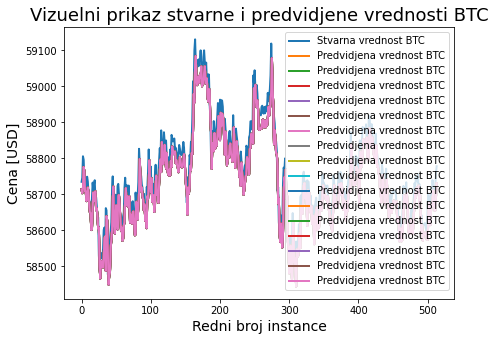

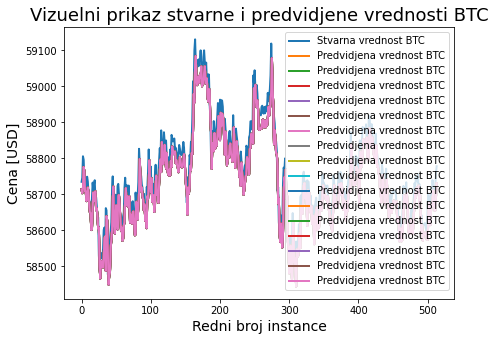

In [118]:
# Plotovanje stvarne i predvidjene vrednosti (output = 16)

test_set = scaler.inverse_transform(y_test.reshape(-1,1))
no_validation_data = scaler.inverse_transform(y_predicted_no_validation)
validation_data = scaler.inverse_transform(y_predicted_validation)

# Bez validacije
plot_real_vs_predicted_data(test_set = test_set, predicted_set = no_validation_data)

# Sa validacijom
plot_real_vs_predicted_data(test_set = test_set, predicted_set = validation_data)


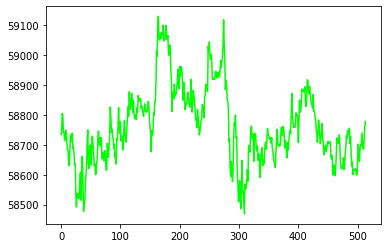

In [97]:
# Plotovanje stvarne vrednosti

plt.plot(test_set, color = 'lime')
#plt.plot(no_validation_data, color = 'blue')

In [98]:
y_test.shape

(514,)

In [99]:
y_predicted_no_validation.shape

(514, 16)

### **Vizuelni prikaz metrika**

### **Srednja apsolutna greška**

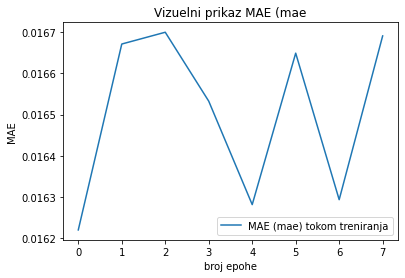

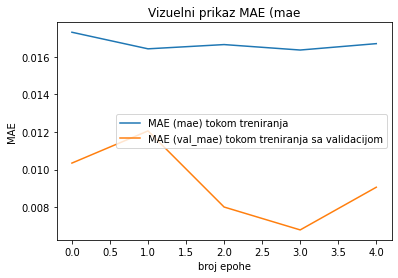

In [103]:
# MAE tokom treniranja mreze

plot_mae(history_no_validation)


# MAE tokom treniranja mreze sa validacijom

plot_mae(history_validation)

### **Funkcija gubitka**

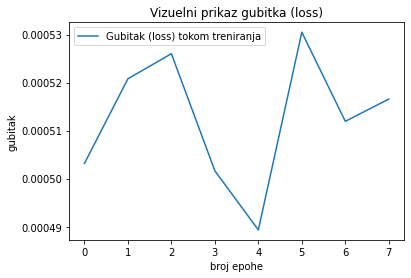

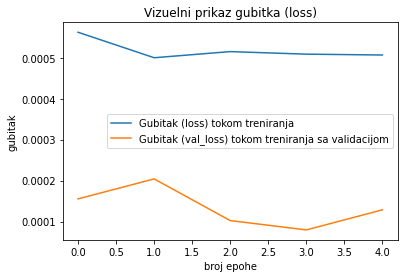

In [104]:
# Loss tokom treniranja mreze

plot_loss(history_no_validation)


# Loss tokom treniranja mreze sa validacijom

plot_loss(history_validation)

### **Srednja kvadratna greška**

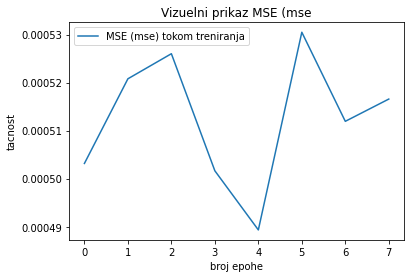

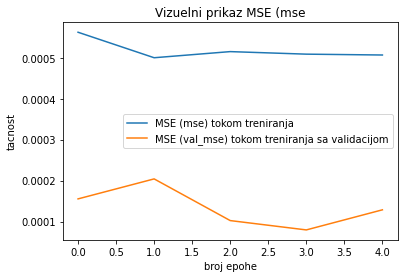

In [105]:
# MSE tokom treniranja mreze

plot_mse(history_no_validation)

# MSE tokom treniranja mreze sa validacijom

plot_mse(history_validation)

In [106]:
# Dimenzije vektora stvarnih i vektora predvidjenih vrednosti y

y_test.shape, y_predicted_no_validation.shape

((514,), (514, 16))

In [107]:
# Uzima se prosecna vrednost predvidjenih

mean_vals = []

for row in y_predicted_no_validation:
  mean_vals.append(row.mean())

mean_vals[:10]

[0.85233456,
 0.8499794,
 0.8527638,
 0.8663348,
 0.86361074,
 0.8511909,
 0.8512813,
 0.8450487,
 0.8478519,
 0.8534925]

In [108]:
# Duzina liste mean_vals

len(mean_vals)

514

In [109]:
# Racunanje MSE za y_predicted_no_validation

mse = MeanSquaredError()

mse(y_test, mean_vals).numpy()

0.00013008669

In [110]:
# Racunanje MSE za y_predicted_validation

mean_vals_ = []

for row in y_predicted_validation:
  mean_vals_.append(row.mean())

mse(y_test, mean_vals_).numpy()

0.00013008669

### **Vizuelni prikaz stvarne i predvidjene vrednosti**

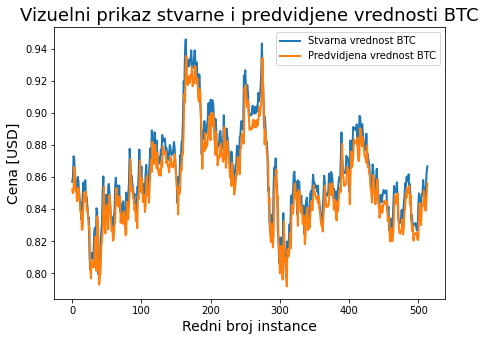

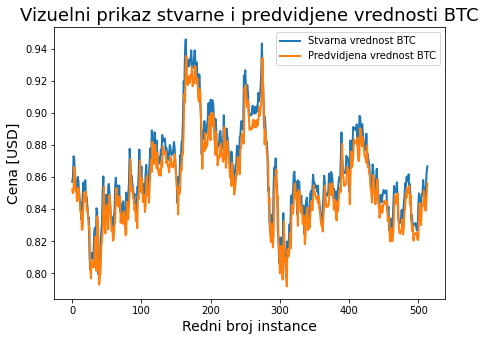

In [111]:
# Plotovanje stvarne i predvidjene vrednosti (prosecne vrednosti predvidjenih)


# Bez validacije

plot_real_vs_predicted_data(test_set = y_test, predicted_set = mean_vals)


# Sa validacijom

plot_real_vs_predicted_data(test_set = y_test, predicted_set = mean_vals_)

### **Loss, MSE, MAE**

In [112]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])

17/17 [==============================] - 0s 9ms/step - loss: 1.3009e-04 - mse: 1.3009e-04 - mae: 0.0091

Metrike prilikom testiranja - model treniran bez validacije

loss 0.00013008667156100273
mse 0.00013008667156100273
mae 0.009137054905295372


Metrike prilikom testiranja - model treniran sa validacijom

loss 0.00013008667156100273
mse 0.00013008667156100273
mae 0.009137054905295372


In [113]:
y_predicted_no_validation.shape, y_test.shape

((514, 16), (514,))

In [114]:
len(mean_vals), len(mean_vals_)

(514, 514)

### **Koeficijent determinacije (R2 skor)**

In [115]:
# R2 skor nad skupom za testiranje

r2 = r2_score(mean_vals, y_test)
r2_val = r2_score(mean_vals_, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije 0.8292359983850264
R2 skor prilikom testiranja - model treniran sa validacijom 0.8292359983850264
